In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Section 1: Data Review and Dependent Variable Definition
I decide to include only those loans with status of 'Fully Paid' and 'Default', 
since the goal for the model is to predict the probability of default for each loan and only those
'Fully Paid' loans will be helpful for us to learn. The loans under 'Fully Paid'
has no chance to be default any more while it might happen to those loan under 'Current' status. 

# Overall, the model will be a binary classification problem to calculate the chance to default for each borrower

In [100]:
#reading file
data = 'data.csv'
loan_data = pd.read_csv(data,sep=',')



Quick view on data 

In [101]:
loan_data.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,last_credit_pull_d,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m
0,88787390,30000,60 months,761.64,6 years,RENT,100100.0,Verified,Sep-2016,Current,...,Dec-2016,709,705,0,0,0,26.0,NaN,0,0.0
1,74722660,30000,60 months,692.93,10+ years,MORTGAGE,235000.0,Source Verified,Apr-2016,Current,...,Dec-2016,649,645,0,0,1,16.0,NaN,1,3.0
2,67919555,16000,60 months,379.39,6 years,RENT,84000.0,Not Verified,Jan-2016,Current,...,Dec-2016,739,735,0,0,0,80.0,NaN,0,2.0
3,54027458,14000,36 months,439.88,5 years,RENT,50000.0,Source Verified,Jul-2015,Fully Paid,...,Oct-2016,749,745,0,0,0,NaN,42.0,0,NaN
4,72594974,7500,36 months,252.67,3 years,MORTGAGE,68000.0,Not Verified,Feb-2016,Fully Paid,...,Dec-2016,709,705,0,0,0,NaN,NaN,2,5.0


# Section 2: Data Cleaning

Missing values check

In [102]:
loan_data.isnull().sum(axis=0).sort_values(ascending=False)/float(len(loan_data))

mths_since_last_record    0.818350
inq_last_12m              0.532563
mths_since_last_delinq    0.477675
emp_length                0.060862
last_credit_pull_d        0.000050
purpose                   0.000000
loan_amnt                 0.000000
term                      0.000000
installment               0.000000
home_ownership            0.000000
annual_inc                0.000000
verification_status       0.000000
issue_d                   0.000000
loan_status               0.000000
dti                       0.000000
addr_state                0.000000
inq_last_6mths            0.000000
earliest_cr_line          0.000000
fico_range_low            0.000000
fico_range_high           0.000000
last_fico_range_high      0.000000
last_fico_range_low       0.000000
acc_now_delinq            0.000000
delinq_amnt               0.000000
delinq_2yrs               0.000000
id                        0.000000
dtype: float64

From the above table, we notice that there are 5 columns in the data set that have missing values and now let's explore these columns and decide whether we need to keep this in the data set.

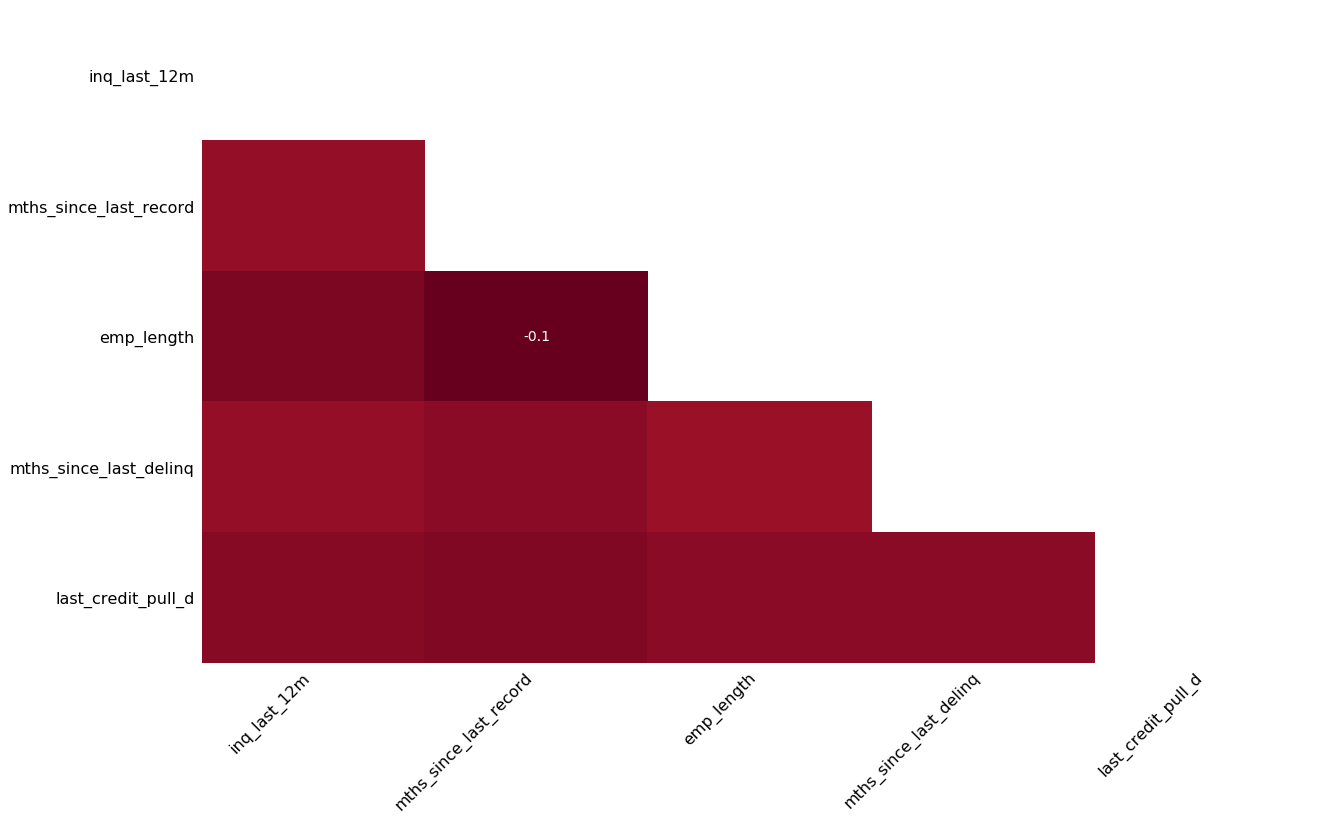

In [28]:
import missingno as msno
#viisualize missing columns in a heatmap
missing_cols = ['inq_last_12m','mths_since_last_record','emp_length','mths_since_last_delinq','last_credit_pull_d']
msno.heatmap(loan_data[missing_cols])

This heatmap shows that there are weak evidence showing any correlation between these columns, and the strongest one has a value of -0.1, which is nearly 0 ( no correlationship) Therefore, we could impute the columns 

Since these columns are missing too many values, there are no points to impute, also, there are no useful information from these columns

In [103]:
drop = ['inq_last_12m','mths_since_last_record','mths_since_last_delinq']
loan_data = loan_data.drop(drop,axis = 1)

In [104]:
#for those categorical columns, 
object_cols = loan_data.select_dtypes(include=['object']).columns 
loan_data[object_cols] = loan_data[object_cols].fillna("Not Available") # fill those object columns with unknown description first

In [105]:
#view on object cols  - we are filling missing values for these columns
object_cols

Index(['term', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state', 'earliest_cr_line',
       'last_credit_pull_d'],
      dtype='object')

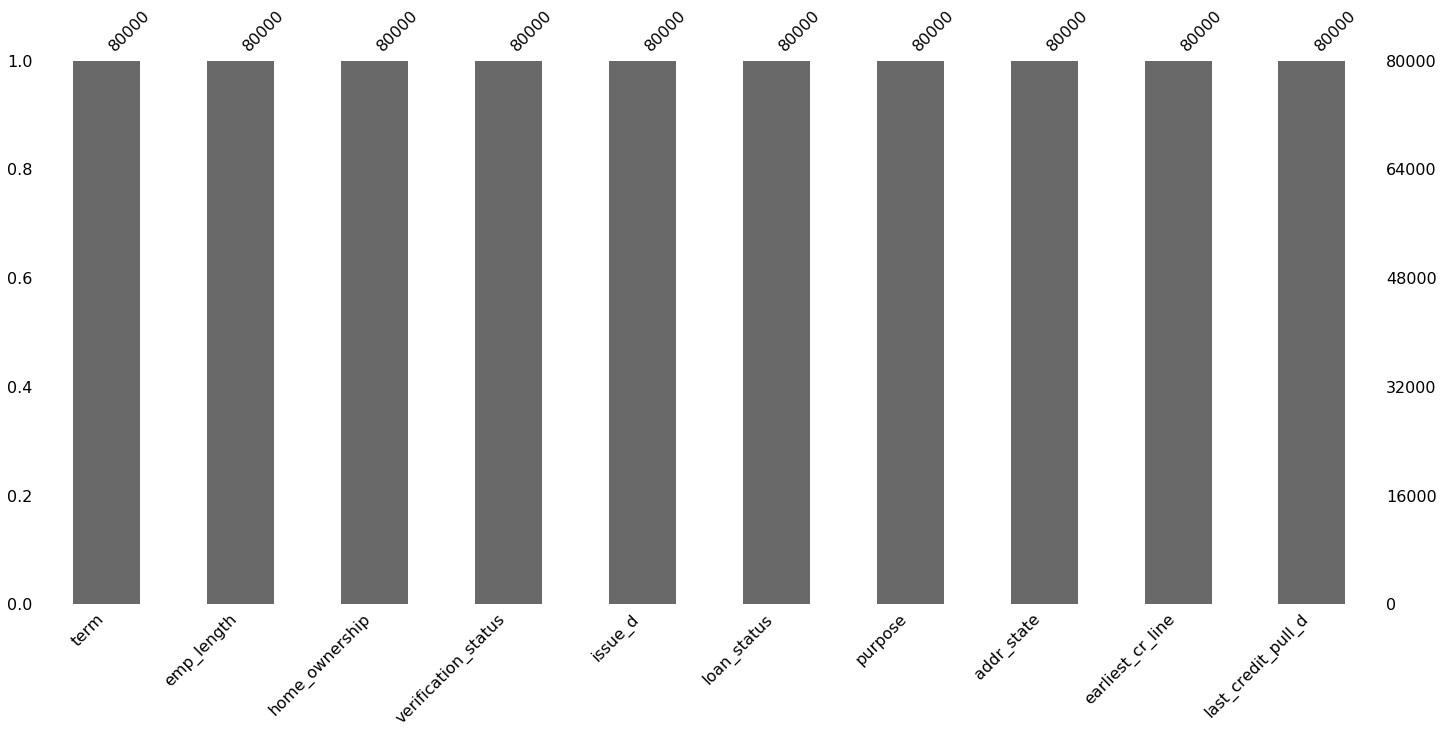

In [106]:
#check if there are other columns have missing values after last step
msno.bar(loan_data[object_cols])  # all clear

There are still other columns with missing values that are numerical 


In [107]:
loan_data.select_dtypes(include=[np.number]).isnull().sum().sort_values(ascending = False) 

inq_last_6mths          0
delinq_2yrs             0
delinq_amnt             0
acc_now_delinq          0
last_fico_range_low     0
last_fico_range_high    0
fico_range_high         0
fico_range_low          0
dti                     0
annual_inc              0
installment             0
loan_amnt               0
id                      0
dtype: int64

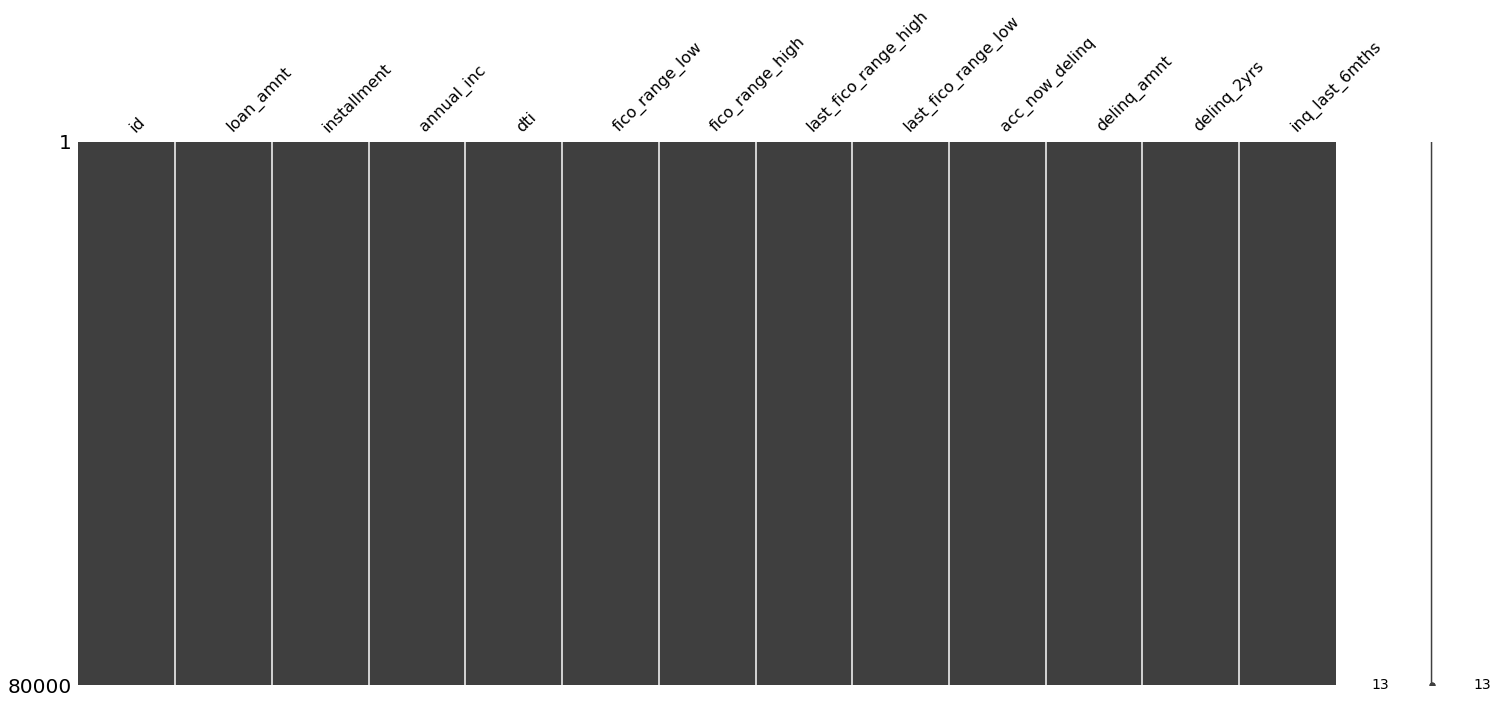

In [108]:
# same way to handle and visualize the result
num_cols = loan_data.select_dtypes(include=[np.number]).columns
msno.matrix(loan_data[num_cols])

Since there are no columns with missing values for numeric , we can move to next step, remove useless columns

Once filled out all the missing values, I could start to filter down the number of columns we need for my final training data set:

1. there are columns that are not meaningful in the dataset, which means that it won't provide any information for the prediciton : id, add_state, earliest_cr_line,last_credit_pull_d 

2. Also, to avoid data leakage, columns like 'issue_d', which means the issuance month of the loan, will leak infomation to the model ,besides that, columns like 'last_fico_range_high', 'last_fico_range_low' also have the same problems, therefore, I choose to remove these columns from the data set

In [110]:
#Remove some columns that are either useless or leaks information
useless = ['id','addr_state','earliest_cr_line','last_credit_pull_d']
loan_data = loan_data.drop(useless,axis=1)

leak_cols = ['issue_d']
loan_data = loan_data.drop(leak_cols,axis=1)

#FICO: since last_fico_range_high/low might leak information in the future about the borrowers, I removed these 2 columns as well
leakage_columns = ['last_fico_range_high','last_fico_range_low']
loan_data = loan_data.drop(leakage_columns,axis=1)

In [111]:
loan_data.shape
loan_data.select_dtypes(include=['object']).columns

Index(['term', 'emp_length', 'home_ownership', 'verification_status',
       'loan_status', 'purpose'],
      dtype='object')

# Feature Engineering 
Now I start to clean data and build up the final data set for modeling


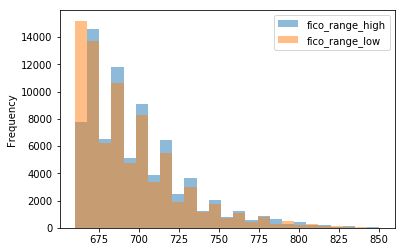

In [112]:
#fico score columns  - generate average score of fico to represent both and drop the original 
#visualize fico score 
fico_col = ['fico_range_high','fico_range_low']
loan_data[fico_col].plot.hist(alpha=0.5,bins=25)
#add fico_avg to represent these two columns
loan_data['fico_avg'] = (loan_data['fico_range_high'] + loan_data['fico_range_low']) / 2
loan_data[['fico_range_high','fico_range_low','fico_avg']].head()
#now drop the original columns
drop_cols = ['fico_range_high','fico_range_low']
loan_data = loan_data.drop(drop_cols,axis=1)

In [113]:
# check if there are any columns that have only 1 values for all rows
loan_data = loan_data.loc[:,loan_data.apply(pd.Series.nunique)!=1]

In [114]:
#1. installment_ratio
loan_data['installment_ratio'] = loan_data['installment'] / (loan_data['annual_inc']/12)  # how difficult for a borrower to pay back the loann

In [115]:
#2. loan_status: mapping
#we are predicting the chance of default, we only include those records that are default or current - a binary classification problem
loans = loan_data[(loan_data['loan_status']=="Fully Paid")|(loan_data['loan_status']=="Default")]
mapping_target = {'loan_status':{'Fully Paid':0,'Default':1}}
loans = loans.replace(mapping_target)

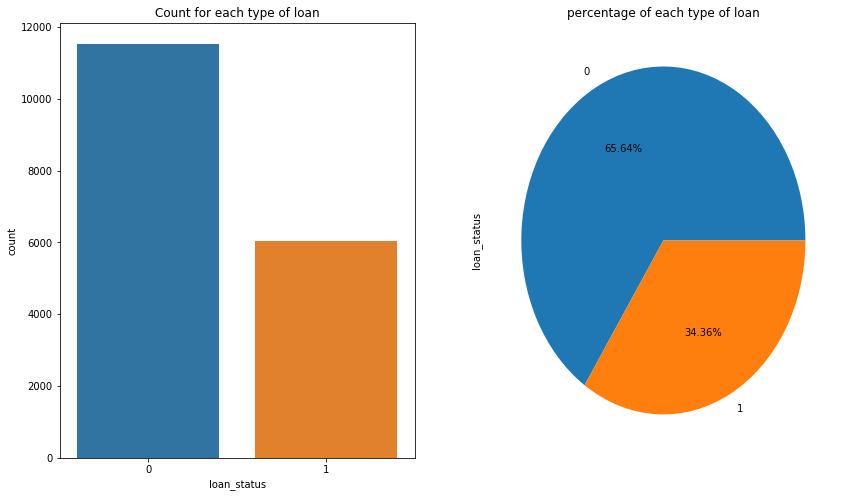

In [116]:
import seaborn as sns
fig,axs = plt.subplots(1,2,figsize=(14,8))
sns.countplot(x='loan_status',data = loans,ax=axs[0])
axs[0].set_title("Count for each type of loan")
loans['loan_status'].value_counts().plot(x=None,y=None,kind='pie',ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("percentage of each type of loan")
plt.show()


The charts show the weight for each type of loan (Fully paid and Default) in the data set and it is clear that we have a imbalance data set and this could be improved later in the modeling part

In [117]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17571 entries, 3 to 79991
Data columns (total 16 columns):
loan_amnt              17571 non-null float64
term                   17571 non-null object
installment            17571 non-null float64
emp_length             17571 non-null object
home_ownership         17571 non-null object
annual_inc             17571 non-null float64
verification_status    17571 non-null object
loan_status            17571 non-null int64
purpose                17571 non-null object
dti                    17571 non-null float64
acc_now_delinq         17571 non-null float64
delinq_amnt            17571 non-null float64
delinq_2yrs            17571 non-null float64
inq_last_6mths         17571 non-null float64
fico_avg               17571 non-null float64
installment_ratio      17571 non-null float64
dtypes: float64(10), int64(1), object(5)
memory usage: 2.9+ MB


Ordinal Variables  - emp_length

In [119]:
#convert into numeric variable
emp_length_map = {"emp_length":{'< 1 year':0.5,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7
                                ,'8 years':8,'9 years':9,'10+ years':10,'Not Available':0}}
loans = loans.replace(emp_length_map)

In [120]:
#view on emp_length after mappinig
loans.head(10)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,inq_last_6mths,fico_avg,installment_ratio
3,14000.0,36 months,439.88,5.0,RENT,50000.0,Source Verified,0,debt_consolidation,21.65,0.0,0.0,0.0,0.0,727.0,0.105571
4,7500.0,36 months,252.67,3.0,MORTGAGE,68000.0,Not Verified,0,debt_consolidation,29.09,0.0,0.0,0.0,2.0,662.0,0.044589
6,25000.0,36 months,870.44,5.0,RENT,55000.0,Verified,0,other,13.35,0.0,0.0,0.0,1.0,757.0,0.189914
7,12000.0,36 months,382.55,5.0,RENT,30000.0,Not Verified,0,debt_consolidation,19.04,0.0,0.0,0.0,0.0,732.0,0.153020
21,30000.0,60 months,677.85,10.0,RENT,84000.0,Verified,0,debt_consolidation,12.03,0.0,0.0,0.0,0.0,722.0,0.096836
22,35000.0,36 months,1182.33,0.5,RENT,90000.0,Verified,0,credit_card,21.97,0.0,0.0,1.0,0.0,667.0,0.157644
24,20000.0,60 months,510.05,2.0,MORTGAGE,170000.0,Not Verified,0,debt_consolidation,18.21,0.0,0.0,0.0,1.0,697.0,0.036004
25,10000.0,60 months,212.43,1.0,OWN,91000.0,Verified,0,home_improvement,7.56,0.0,0.0,1.0,0.0,752.0,0.028013
30,8000.0,36 months,263.93,0.0,RENT,72000.0,Source Verified,0,debt_consolidation,18.40,0.0,0.0,0.0,0.0,682.0,0.043988
35,10000.0,36 months,344.02,0.0,MORTGAGE,60000.0,Verified,0,medical,34.02,0.0,0.0,0.0,1.0,662.0,0.068804


Nominal Variables - term, home_ownership,verification_status,purpose


In [121]:
nominal_cols = ['term','home_ownership','verification_status','purpose']


In [122]:
dummy_var = pd.get_dummies(loans[nominal_cols])
loans = pd.concat([loans,dummy_var],axis=1)
loans = loans.drop(nominal_cols,axis=1)

In [123]:
loans.head()

,loan_amnt,installment,emp_length,annual_inc,loan_status,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,inq_last_6mths,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
3,14000.0,439.88,5.0,50000.0,0,21.65,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,7500.0,252.67,3.0,68000.0,0,29.09,0.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
6,25000.0,870.44,5.0,55000.0,0,13.35,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,0
7,12000.0,382.55,5.0,30000.0,0,19.04,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
21,30000.0,677.85,10.0,84000.0,0,12.03,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Feature Scaling - Standarization

In [124]:
#scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [125]:
# we only need to standardize those float / int columns
col = loans.select_dtypes(include=['int64','float64']).columns
col = col.drop('loan_status') # not include dependent variables
#loans[~loans.isin([np.nan, np.inf, -np.inf]).any(1)]  - for all inf values

In [126]:
loan_ml = loans
loan_ml = loan_ml.replace([np.inf, -np.inf], np.nan)
loan_ml.dropna(inplace=True)

loan_ml[col] = sc.fit_transform(loan_ml[col])
loan_ml.head()  # after scaling

,loan_amnt,installment,emp_length,annual_inc,loan_status,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,inq_last_6mths,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
3,-0.115614,-0.038686,-0.179308,-0.274020,0,0.295574,-0.08309,-0.021401,-0.36351,-0.716194,...,0,0,0,0,0,0,0,0,0,0
4,-0.849180,-0.748090,-0.704118,-0.094216,0,1.131834,-0.08309,-0.021401,-0.36351,1.390364,...,0,0,0,0,0,0,0,0,0,0
6,1.125805,1.592856,-0.179308,-0.224075,0,-0.637350,-0.08309,-0.021401,-0.36351,0.337085,...,0,0,0,0,0,1,0,0,0,0
7,-0.341327,-0.255929,-0.179308,-0.473803,0,0.002209,-0.08309,-0.021401,-0.36351,-0.716194,...,0,0,0,0,0,0,0,0,0,0
21,1.690087,0.863066,1.132718,0.065611,0,-0.785719,-0.08309,-0.021401,-0.36351,-0.716194,...,0,0,0,0,0,0,0,0,0,0


# Section 3: Analysis

To select the right features for modeling, first of all, I would take a look on the correlation between each columns so that we could remove some highly correlated features

In [130]:
x_col = list(loan_ml.columns)
x_col.remove('loan_status')

In [132]:
X = loan_ml[x_col]
y = loan_ml['loan_status']

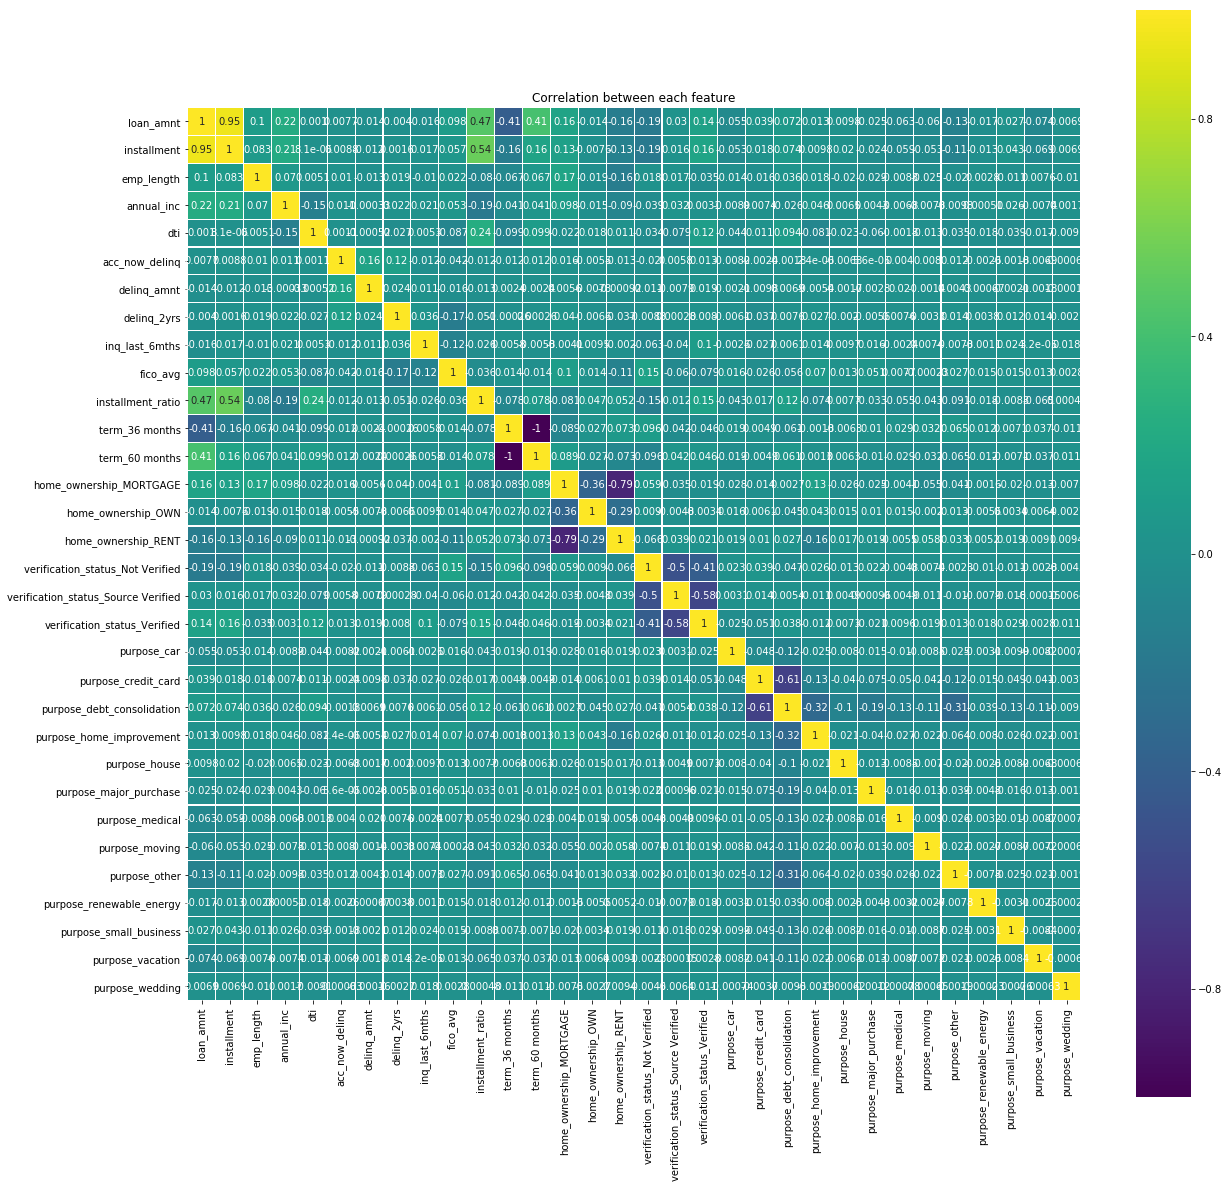

In [138]:
heatmap1 = plt.cm.viridis
plt.figure(figsize=(20,20))
plt.title("Correlation between each feature")
sns.heatmap(X.corr(),linewidths = 0.2,vmax =1,square = True,cmap = heatmap1,annot=True,linecolor = 'white')

According to the Pearson's coeffience, the following columns can be removed

In [149]:
remove = ['installment','home_ownership_RENT','home_ownership_OWN','verification_status_Source Verified',
          'term_36 months','purpose_credit_card']


In [150]:
filtered_col = []
for col in x_col:
    if col not in remove:
        filtered_col.append(col)

x_col = filtered_col

In [152]:
len(x_col)

26

In [153]:
X = loan_ml[x_col]  # update X 

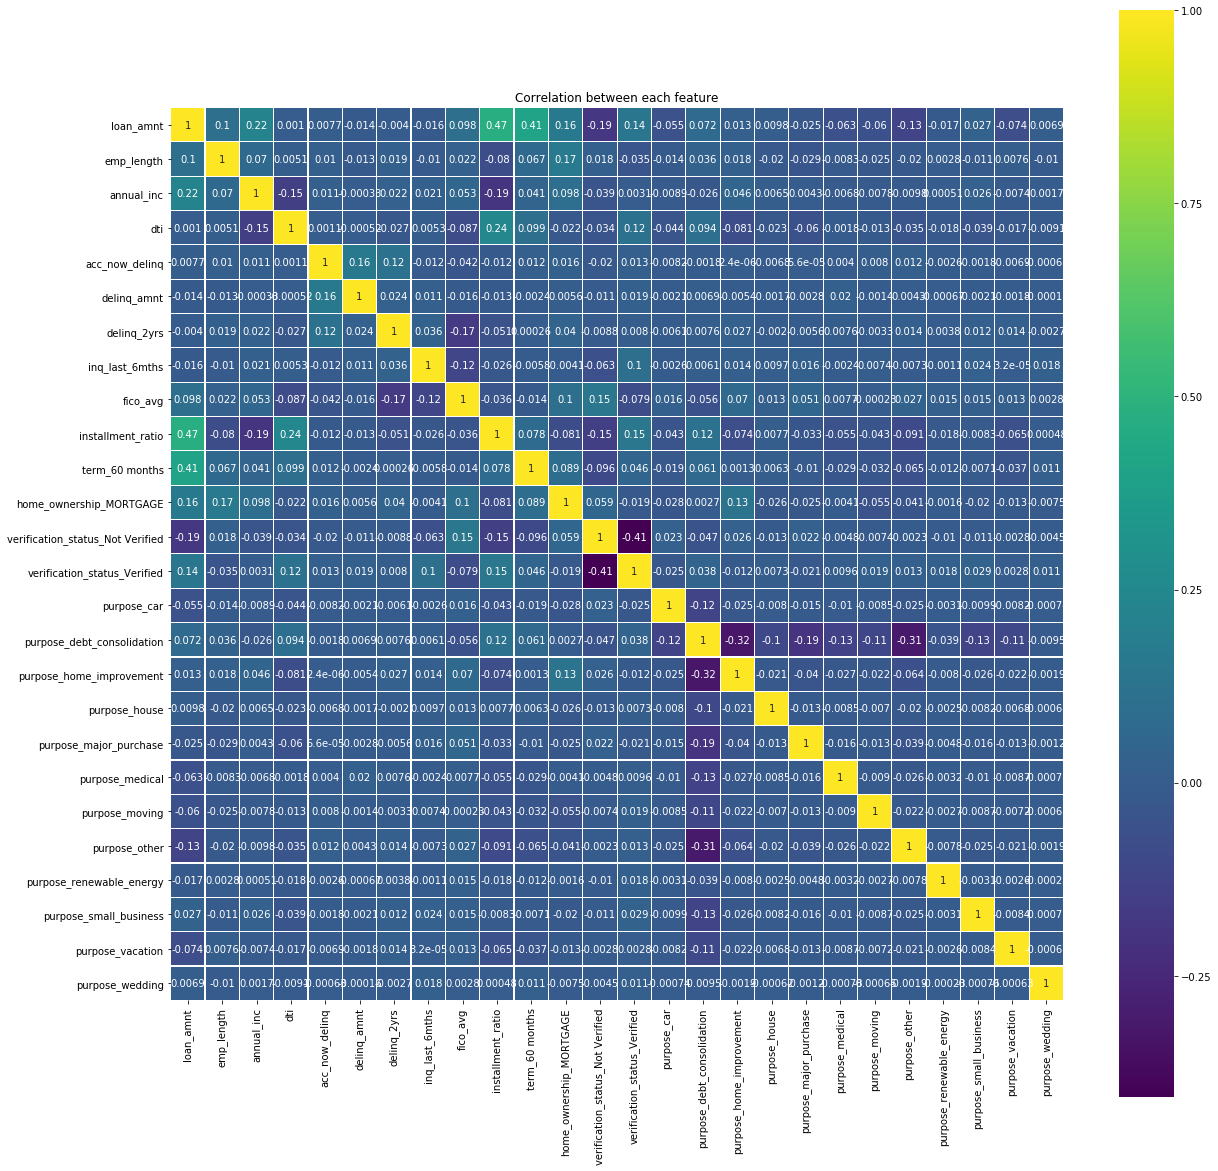

In [154]:
#check it after removing
heatmap2 = plt.cm.viridis
plt.figure(figsize=(20,20))
plt.title("Correlation between each feature")
sns.heatmap(X.corr(),linewidths = 0.2,vmax =1,square = True,cmap = heatmap1,annot=True,linecolor = 'white')

Here I choose Random Forest as the model to figure out what feautures are the most important


In [155]:
col_name = loan_ml[x_col].columns

In [157]:
from sklearn.cross_validation import train_test_split
x_train,x_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)


C:\Users\karen\Anaconda3_v3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [158]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 10,random_state = 0)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

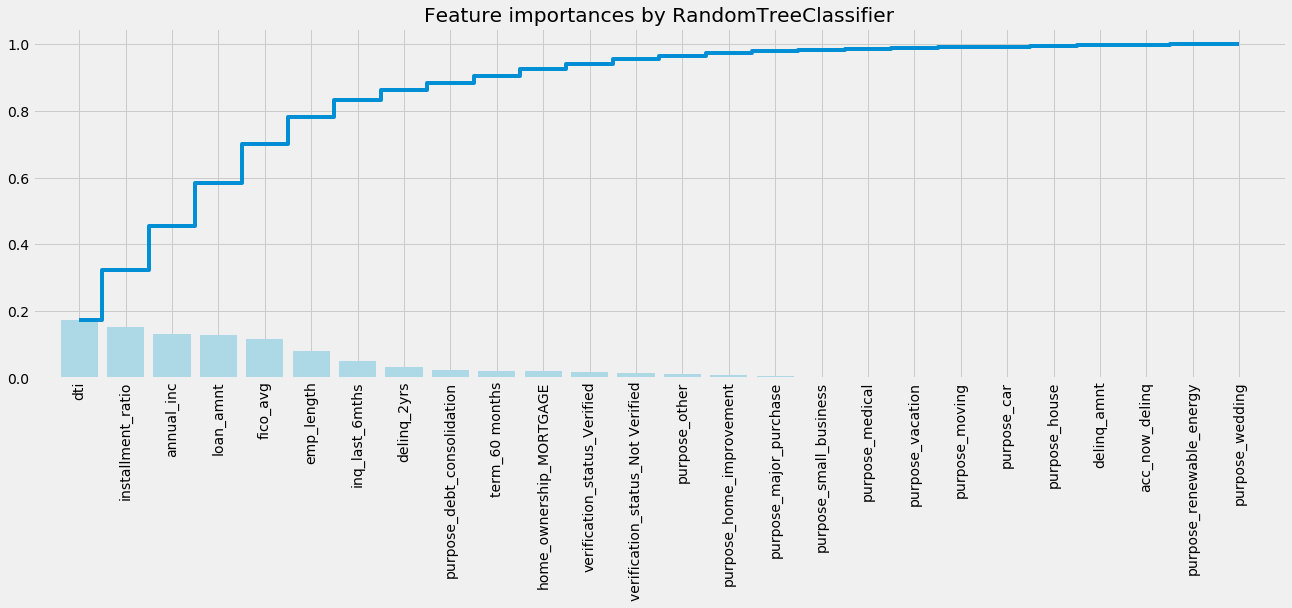

In [160]:
#visualize the feature importance
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,12)


importances = clf.feature_importances_
feat_names = col_name
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

 2. Eliminate more features to reach a number of 20 features in the model

In [161]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

rfe = RFE(model, 20) #select 20 features by using recursive feature elimination
rfe = rfe.fit(X, y)

print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True False False False  True  True  True  True  True
  True  True False  True  True  True  True  True False  True  True  True
  True  True]
[2 1 1 1 5 6 4 1 1 1 1 1 1 1 7 1 1 1 1 1 3 1 1 1 1 1]


The ranking for the last line above means that if it is 1, it means the feature is selected 

In [163]:
x_col = X.columns[rfe.support_]

In [164]:
x_col # after elimination

Index(['emp_length', 'annual_inc', 'dti', 'inq_last_6mths', 'fico_avg',
       'installment_ratio', 'term_60 months', 'home_ownership_MORTGAGE',
       'verification_status_Not Verified', 'verification_status_Verified',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

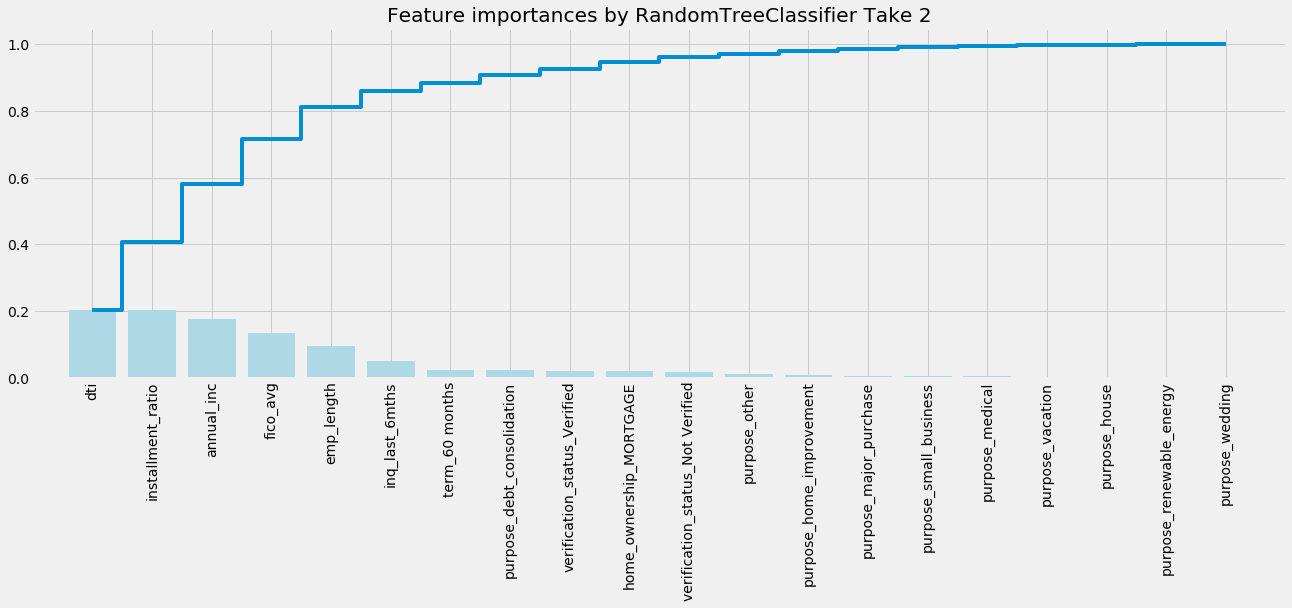

In [167]:
X = X[x_col]
# repeat the steps
x1_train,x1_test, y1_train,y1_test = train_test_split(X,y,test_size=0.3,random_state=321)
clf2 = RandomForestClassifier(n_estimators = 50,random_state = 321)
clf2.fit(x1_train,y1_train)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,12)

col_name = loan_ml[x_col].columns
importances = clf2.feature_importances_
feat_names = col_name
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier Take 2")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Feature importance
The most important feature is dti, followed by installment ratio, annual income, loan_amnt, and fico average

# Imbalanced class

In [169]:
X_imb = loan_ml[filtered_col]
y = loan_ml['loan_status']

# Use SMOTE for oversampling
data_size = y.shape[0]
positive_sample = y[y == 0].shape[0]
negative_sample = y[y == 1].shape[0]

In [170]:
print("Before SMOTE, there are {} rows of data, with {:.2%} for Default and {:.2%} for Fully Paid".format(data_size,positive_sample/data_size,negative_sample/data_size))

Before SMOTE, there are 17570 rows of data, with 65.65% for Default and 34.35% for Fully Paid


In [173]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=123)    # 处理过采样的方法
X_imb, y = sm.fit_sample(X_imb, y)

data_size = y.shape[0]
positive_sample = y[y == 0].shape[0]
negative_sample = y[y == 1].shape[0]

print("After SMOTE,there are {} rows of data, with {:.2%} for Default and {:.2%} for Fully Paid".format(data_size,positive_sample/data_size,negative_sample/data_size))

After SMOTE,there are 23068 rows of data, with 50.00% for Default and 50.00% for Fully Paid


In [174]:
x2_train,x2_test,y2_train,y2_test = train_test_split(X_imb,y,test_size=0.3,random_state=111)
from sklearn.model_selection import GridSearchCV
#use GridSearch for best combination of the parameters
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
grid_search.fit(x2_train, y2_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Model Evaluation

In [179]:
y2_pred = grid_search.predict(x2_test)

#show confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y2_test,y2_pred)

array([[2101, 1375],
       [1182, 2263]], dtype=int64)

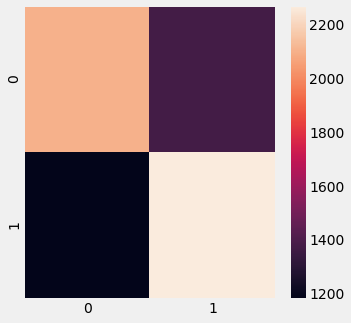

In [181]:
cm = confusion_matrix(y2_test,y2_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm)

In [185]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y2_test,y2_pred)


In [186]:
print(roc_auc)

0.6306622145468576


In [188]:
#compare to the previous model
y_pred = clf2.predict(x1_test)
roc_auc2 = roc_auc_score(y1_test,y_pred)
print(roc_auc2)

0.5643256136011651


# Overall , the model has been improved from 56% to 63% in terms of ROC_AUC